[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cyneuro/Borgers-Examples-in-BMTK/blob/main/23-WBneuron/23_WBEntrainment_model.ipynb)

# Modeling Entrainment of a WB Neuron (with BMTK)
#### by Matthew Stroud and Gregory Glickert

In this notebook, we model 1:1 entrainment of a standard WB neuron under a constant frequency of excitatory input pulses. The entrainment is 1:1 because the WB neuron will fire at the same frequency as the input.


## Cell Definition
A standard WB cell is used in this example. 

**WB Cell**
* $\alpha_{n} = -0.01*(v+34)/(e^{-0.1*(v+34)}-1)$
* $\beta_{n} = 0.125*e^{-(v+44)/80}$
* $\alpha_{m} = 0.1*(v+35)/(1-e^{-(v+35)/10})$
* $\beta_{m} = 4*e^{-(v+60)/18}$
* $\alpha_{h} = 0.07*e^{-(v+58)/20}$
* $\beta_{h} = 1/(e^{-0.1*(v+28)}+1)$

Compile .mod Files

In [1]:
import os
from os.path import normpath, sep, join

RunningInCOLAB = 'google.colab' in str(get_ipython()) 
if RunningInCOLAB:  
  %pip install neuron==8.2.4 &> /dev/null
  %pip install bmtk &> /dev/null

  root = 'Borgers-Examples-in-BMTK' # name of github repo
  folder = '23-WBneuron' # name of folder in Github just change this line 
  pathlist = normpath(os.getcwd()).split(sep)
  if pathlist[-1] != folder:
    rootidx = pathlist.index(root) if root in pathlist else -1
    if rootidx>0:
      os.chdir(join(sep,*pathlist[:rootidx]))
    !git clone https://github.com/Cyneuro/Borgers-Examples-in-BMTK
    os.chdir(join(root,folder))
    
print(os.system('nrnivmodl components/mechanisms')) # compile modfiles. Return 0 for success, 1 for failure.

/home/gjgpb9/Borgers-Examples-in-BMTK/23-WBneuron
Mod files: "components/mechanisms/components/mechanisms/k_wb.mod" "components/mechanisms/components/mechanisms/leak.mod" "components/mechanisms/components/mechanisms/na_wb.mod" "components/mechanisms/components/mechanisms/vecevent.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../components/mechanisms/k_wb.mod
 -> NMODL ../components/mechanisms/leak.mod
 -> NMODL ../components/mechanisms/na_wb.mod
 -> NMODL ../components/mechanisms/vecevent.mod
 -> Compiling leak.c
 -> Compiling k_wb.c
Notice: ARTIFICIAL_CELL is a synonym for POINT_PROCESS which hints that it
only affects and is affected by discrete events. As such it is not
located in a section and is not associated with an integrator
 -> Compiling na_wb.c
 -> Compiling vecevent.c
 => LINKING shared library ./libnrnmech.so


/home/gjgpb9/miniconda3/envs/bmtk/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Translating k_wb.mod into /home/gjgpb9/Borgers-Examples-in-BMTK/23-WBneuron/x86_64/k_wb.c
Translating leak.mod into /home/gjgpb9/Borgers-Examples-in-BMTK/23-WBneuron/x86_64/leak.c
Translating na_wb.mod into /home/gjgpb9/Borgers-Examples-in-BMTK/23-WBneuron/x86_64/na_wb.c
Thread Safe
Thread Safe
Thread Safe
Translating vecevent.mod into /home/gjgpb9/Borgers-Examples-in-BMTK/23-WBneuron/x86_64/vecevent.c
Thread Safe


 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/special
0


### 1.Building the Network
There is only 1 cell in this network, thus only a WB cell will be added. No network connections are necessary

In [2]:
import numpy as np
import logging

from bmtk.builder.networks import NetworkBuilder

net = NetworkBuilder('network')
net.add_nodes(N=1,pop_name='WB',     
        model_type='biophysical',
        model_template='hoc:WBInhCell',  # WBInhCell hoc definition
        morphology='blank.swc')

#### Building
After defining our network, we build and save it in a network folder.

In [3]:
net.build()
net.save_nodes(output_dir='network')

#### External Input
We then create a 'virtual' cell that supplies the excitatory synaptic input to our WB cell.

In [4]:
extnet = NetworkBuilder('extnet')
extnet.add_nodes(N=1,pop_name='Inp',
            potential='exc',
            model_type='virtual')

Add an excitatory connection from our virtual cell to the WB cell using tau1=0.5 ms and t2=2 ms. These parameters are specified in ExcToInh.json

In [5]:
extnet.add_edges(source={'pop_name':'Inp'}, target=net.nodes(),
                   connection_rule=1,
                   syn_weight=0.03,               #synaptic weight specified in Borger's book ch 23
                   delay=5,
                   weight_function=None,
                   target_sections=['soma'],
                   distance_range=[0.0, 150.0],
                   dynamics_params='ExcToInh.json',
                   model_template='exp2syn')

In [6]:
extnet.build()
extnet.save_nodes(output_dir='network')
extnet.save_edges(output_dir='network')

#### Adding Spike Train

In [7]:
from bmtk.utils.reports.spike_trains import SpikeTrains

spikes = SpikeTrains(population='extnet')
spikes.add_spikes(node_ids=0, 
                    timestamps=[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800])
spikes.to_sonata('input/ConstantSpike.h5')

This next cell is used to build the simulation. This step is already completed for you.

In [8]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='.',
                network_dir='network',
                 tstop=800.0, dt=0.1,
                 report_vars=['v'],     # Record membrane potential and calcium (default soma)
                 spikes_inputs=[('extnet',   # Name of population which spikes will be generated for
                                'input/ConstantSpike.h5')],
                 include_examples=False,    # Copies components files
                 compile_mechanisms=False,   # Will try to compile NEURON mechanisms
                 config_file = 'config.json'
                )

### Run the Simulation

In [9]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

numprocs=1
2025-01-24 10:49:43,752 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


NEURON mechanisms not found in /home/gjgpb9/Borgers-Examples-in-BMTK/23-WBneuron/components/mechanisms.
2025-01-24 10:49:43,816 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2025-01-24 10:49:43,818 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2025-01-24 10:49:43,819 [INFO] Building virtual cell stimulations for extnet_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for extnet_spikes


2025-01-24 10:49:43,828 [INFO] Running simulation for 800.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 800.000 ms with the time step 0.100 ms


2025-01-24 10:49:43,829 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2025-01-24 10:49:43,830 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2025-01-24 10:49:43,938 [INFO]     step:5000 t_sim:500.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:500.00 ms


2025-01-24 10:49:44,005 [INFO]     step:8000 t_sim:800.00 ms


INFO:NEURONIOUtils:    step:8000 t_sim:800.00 ms


2025-01-24 10:49:44,012 [INFO] Simulation completed in 0.1834 seconds 


INFO:NEURONIOUtils:Simulation completed in 0.1834 seconds 


If the simulation ran correctly, we can now print out results:

In [10]:
from bmtk.analyzer.spike_trains import to_dataframe

results_df = to_dataframe(config_file='config.json')
print('Number of Spikes: {}'.format(len(results_df)))
results_df.head()

Number of Spikes: 5


,timestamps,node_ids,population
0,174.5,0,network
1,322.1,0,network
2,471.4,0,network
3,621.2,0,network
4,771.2,0,network


As you can see, the WB neuron fired ~7.8 ms after the spike in our virtual cell. We defined 5 ms delay in our synapse, so if this delay is set to 0 and the simulation is re-run, the WB neuron would fire ~2.8 ms after the virtual cell spike.

We can now plot our results using an in built bmtk function plot_traces

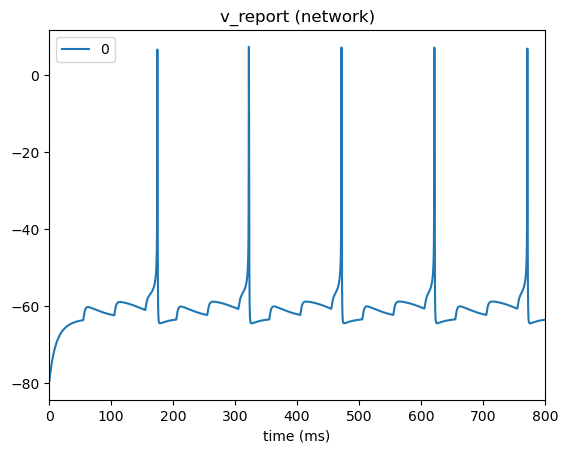

In [11]:
from bmtk.analyzer.compartment import plot_traces
_ = plot_traces(config_file='config.json', node_ids=[0], report_name='v_report')


## Additional Plot Features
It is easier to work with this data if we obtain it in array form, and we can use well documented matplotlib features while plotting.

In [12]:
from bmtk.utils.reports.compartment import CompartmentReport

pop_name = 'WB'
report = CompartmentReport('output/v_report.h5',
population=pop_name, mode='r')
v_trace = (report.data(node_id=0))
time = np.arange(report.tstart(), report.tstop(), report.dt())

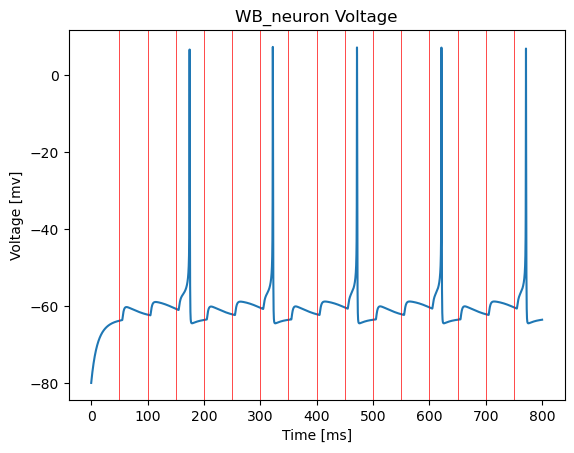

In [13]:
import matplotlib.pyplot as plt
plt.plot(time, v_trace)
plt.ylabel('Voltage [mv]')
plt.xlabel('Time [ms]')
plt.title('WB_neuron Voltage')
# add red verticle lines that mark when the virtual cell spikes
for i in range(15):
    plt.axvline(x=50*i+50, linewidth=0.5, color='r')
plt.show()

After overlaying the virtual cell spike times (vertical red lines) we have created a plot that looks very similar to the example in chapter 23 of Borgers' book, "An Introduction to Modeling Neuronal Dynamics."